In [1]:
#spam
#Naive Bayes
#get word count from spam and ham

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from glob import glob
ham_files = glob('data/enron1/ham/*.txt')
spam_files = glob('data/enron1/spam/*.txt')

def read_emails(files):
    tmp = []
    for path in files:
        with open(path) as f:
            tmp.append(f.read())
    return tmp

ham_emails = read_emails(ham_files)
spam_emails = read_emails(spam_files)

ham_prior = float(len(ham_emails))/(len(ham_emails)+len(spam_emails))
spam_prior = float(len(spam_emails))/(len(ham_emails)+len(spam_emails))
print ham_prior, spam_prior # percentage of each type of emails

0.709976798144 0.290023201856


In [3]:
import re
def cleanup(w):
    s = w.lower()
    return re.sub(r'[^a-zA-Z]', '', s)

def tokenize(email):
    tokens = email.split(' ')
    clean_tokens = map(cleanup , tokens)
    conjunctions = set(['a','the','an','in','on','at','of','by','','is','not','if','or','and','to','this','that','be','am','are','ect','for','hou','will','subject'])
    clean_tokens = filter(lambda x: x not in conjunctions and len(x)>2, clean_tokens)
    return clean_tokens

def word_counts(tokens):
    ret = {}
    for w in tokens:
        old = ret[w] if w in ret else 0
        ret[w] = old+1
    return ret

def calculate_probs(emails):
    s = ' '.join(emails)
    tokens = tokenize(s)
    wc = word_counts(tokens)
    num_words = len(tokens)
    probs = {k: v/float(num_words) for k, v in wc.iteritems()}
    return probs, num_words

In [4]:
ham_probs, ham_num_words = calculate_probs(ham_emails)
spam_probs, spam_num_words = calculate_probs(spam_emails)

In [5]:
def top_words(probs, n, title):
    ham_top = sorted(probs.iteritems(), key=lambda x: x[1], reverse=True)[:n]
    x = [xx[0] for xx in ham_top]
    y = [xx[1] for xx in ham_top]
    plt.figure(figsize=(20,6))
    plt.bar(range(len(x)),y)
    plt.xticks(range(len(x)), x)
    plt.title(title)   

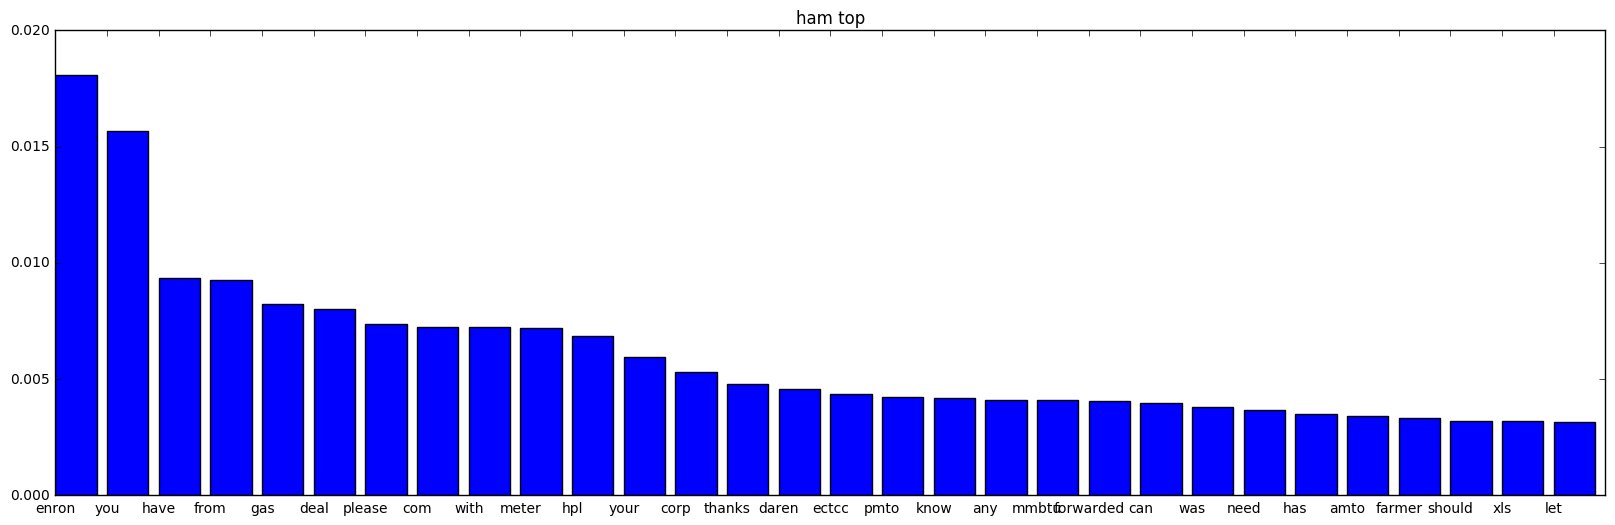

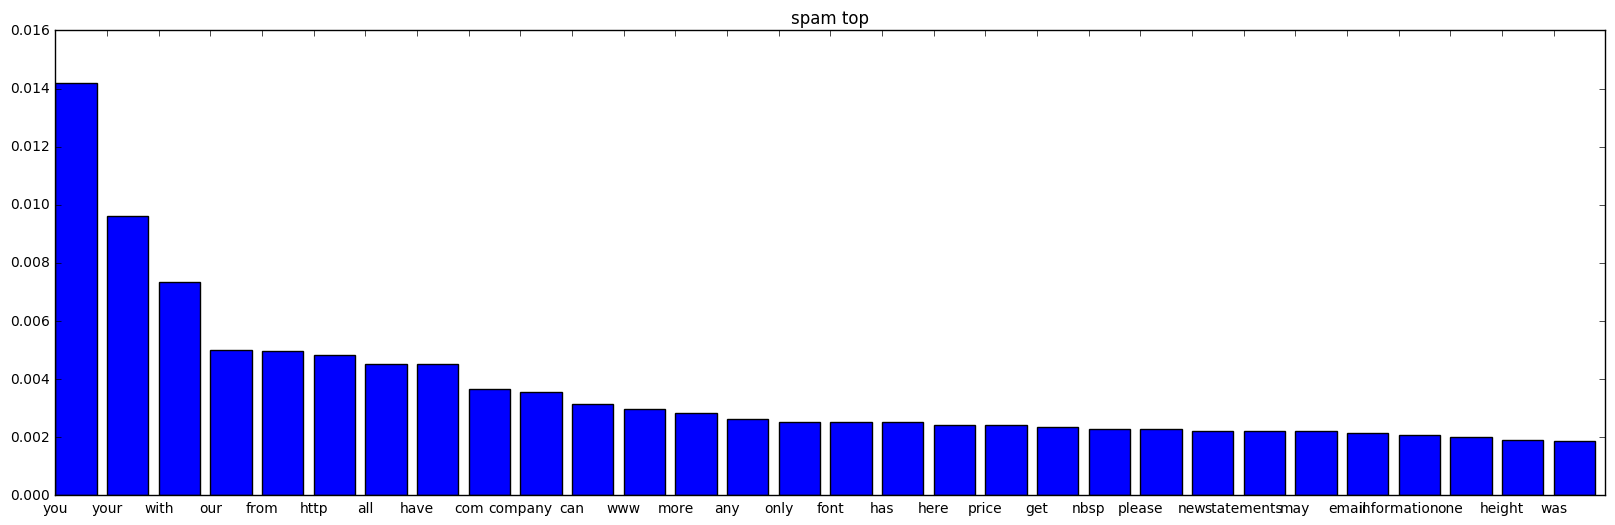

In [6]:
top_words(ham_probs, 30, 'ham top')
top_words(spam_probs, 30, 'spam top')

In [7]:
import math

def log_prob(email, probs, prior, total_train):
    tokens = tokenize(email)
    p = math.log(prior)
    for token in tokens:
        if token in probs:
            p+=math.log(probs[token])
        else:
            p+=math.log(0.01/total_train)
    return p

def log_prob_spam(email):
    return log_prob(email, spam_probs, spam_prior, spam_num_words)

def log_prob_ham(email):
    return log_prob(email, ham_probs, ham_prior, ham_num_words)

def cap(low, x, high):
    if x < low:
        return low
    if x > high:
        return high
    return x

def prob(email):
    ls = log_prob_spam(email)
    lh = log_prob_ham(email)
    exponent = cap(-200, lh-ls, 200)
    spam_prob = 1.0/(1+math.exp(exponent))
    return spam_prob, 1-spam_prob

(array([  2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.66300000e+03]),
 array([ 0.00151283,  0.10136155,  0.20121026,  0.30105898,  0.4009077 ,
         0.50075642,  0.60060513,  0.70045385,  0.80030257,  0.90015128,  1.        ]),
 <a list of 10 Patch objects>)

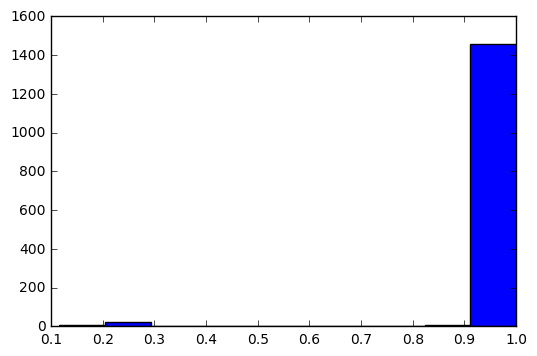

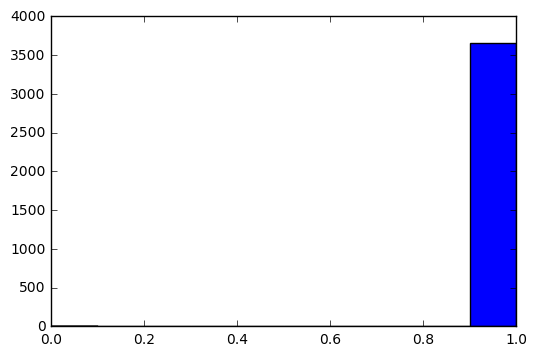

In [11]:
spam_result = [prob(email)[0] for email in spam_emails]
ham_result = [prob(email)[1] for email in ham_emails]
plt.hist(spam_result)
plt.figure()
plt.hist(ham_result)

In [9]:
test_ham_files = glob('data/enron2/ham/*.txt')
test_spam_files = glob('data/enron2/spam/*.txt')

0.916168687041


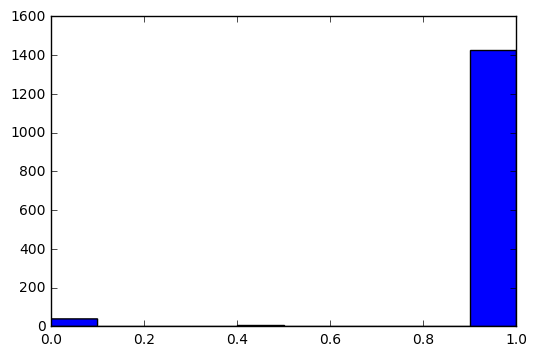

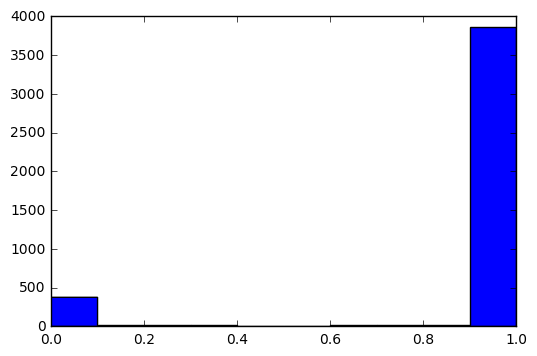

In [15]:
test_spam_emails = read_emails(test_spam_files)
test_ham_emails = read_emails(test_ham_files)

spam_result = [prob(email)[0] for email in test_spam_emails]
ham_result = [prob(email)[1] for email in test_ham_emails]

plt.hist(spam_result)
plt.figure()
plt.hist(ham_result)

num_correct_spam = sum( 1 if res > 0.5 else 0 for res in spam_result)
num_correct_ham = sum( 1 if res > 0.5 else 0 for res in ham_result)

print float(num_correct_spam + num_correct_ham)/(len(spam_result)+len(ham_result))
# Printing the accuracy